## Predicting Hospital Readmission Rates of Patients With Diabetes Mellitus
### CS5450 Machine Learning Project
#### Dec. 10, 2018

#### Team Members
Jared Weed, Shaozhi Jiang

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.weightstats import ztest
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Import warnings to suppress dependency warnings from certain packages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Make plots inline for the purpose of the notebook
%matplotlib inline

# show larger frames
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

# Format floats
pd.options.display.float_format = '{:.8f}'.format

In [3]:
raw_data = pd.read_csv('diabetic_data.csv')
for column in raw_data.columns:
    print(column)
print(raw_data.shape)
raw_data.head(n=2).T

encounter_id
patient_nbr
race
gender
age
weight
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
payer_code
medical_specialty
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
diag_1
diag_2
diag_3
number_diagnoses
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted
(101766, 50)


,0,1
encounter_id,2278392,149190
patient_nbr,8222157,55629189
race,Caucasian,Caucasian
gender,Female,Female
age,[0-10),[10-20)
weight,?,?
admission_type_id,6,1
discharge_disposition_id,25,1
admission_source_id,1,7
time_in_hospital,1,3


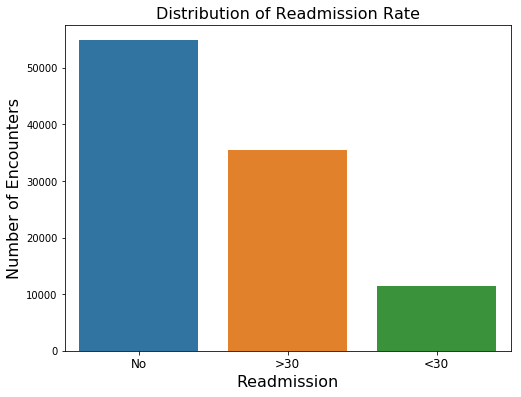

In [4]:
plt.figure(figsize=(8,6))
sns.countplot(raw_data['readmitted']);
plt.title("Distribution of Readmission Rate", size=16);
plt.xlabel("Readmission", size=16);
plt.xticks([0,1,2], ['No','>30', '<30'], size=12)
plt.ylabel("Number of Encounters", size=16);
plt.savefig('readmission1.png')
plt.show()

#### Make the data i.i.d
We first must remove duplicate and dependent data from the dataset to ensure we are working with independent and identically distributed datapoints. Some data entries have a dependency for readmission (or not readmission) because they may have been sent home on hospice or deceased (hence would never be readmitted). Additionally, some patient numbers are found more than once, which means we have a dependency on readmission rates if they are present twice in the dataset. We keep only the first encounter of each patient number.

In [5]:
# Determine duplicates in the dataset
duplicates = raw_data.duplicated(subset=['patient_nbr'])

# Capture all datapoints with disposition ids that relate to 
# patients that are sent to hospice care or were recorded as deceased
dependents = raw_data[raw_data['discharge_disposition_id'].isin([11,13,14,19,20,21])]

data = raw_data.drop(np.union1d(duplicates[duplicates == True].index,
                                dependents[dependents == True].index))

In [6]:
print(data.shape)

(69973, 50)


#### Change the dependent variable to a two-class category
We do this by investigating only the case where a patient is readmitted within 30 days, or otherwise not readmitted within that time (not admitted at all is classified in this case as well as "not within 30 days")

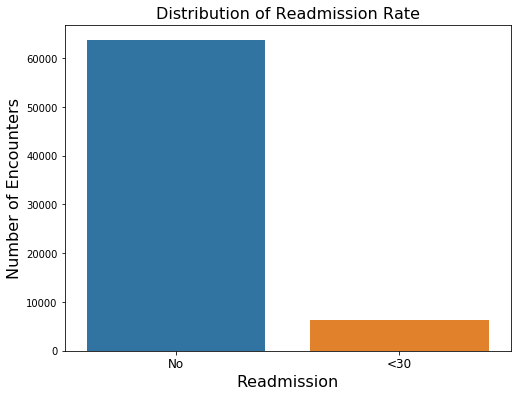

In [7]:
# Create a new feature that is a mapping of readmission 
# rates for patients under 30 days
data['readmission'] = data['readmitted'].map({'NO':0, 
                                              '>30':0, 
                                              '<30':1})

# Show the new distribution
plt.figure(figsize=(8,6))
sns.countplot(data['readmission']);
plt.title("Distribution of Readmission Rate", size=16);
plt.xlabel("Readmission", size=16);
plt.xticks([0,1], ['No', '<30'], size=12)
plt.ylabel("Number of Encounters", size=16);
plt.savefig('readmission2.png')
plt.show()

## Feature Investigation

#### Time in Hospital

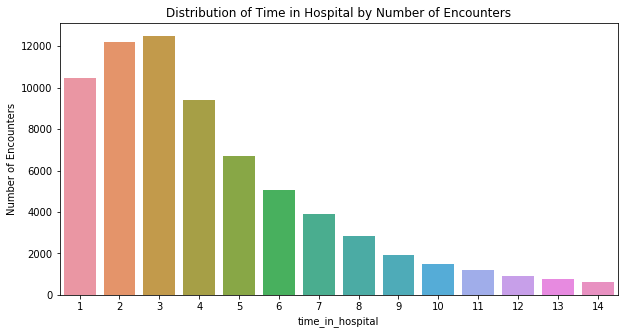

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(data['time_in_hospital'])
plt.title("Distribution of Time in Hospital by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.savefig('fig1.png')
plt.show()

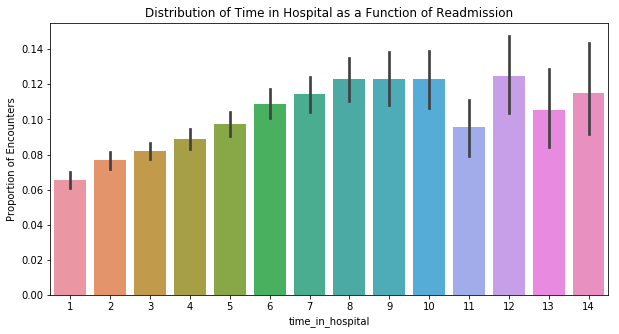

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(data['time_in_hospital'], data['readmission']);
plt.title("Distribution of Time in Hospital as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.savefig('fig2.png')
plt.show()

In [10]:
# To keep the linear increasing relationship of time_in_hospital, 
# create a new feature that merges 1-3, 4-7, >7 days together
data['length_of_stay'] = data['time_in_hospital'].replace([1,2,3], '1-3days') \
.replace([4,5,6,7], '4-7days').replace([8,9,10,11,12,13,14], '8-14days')

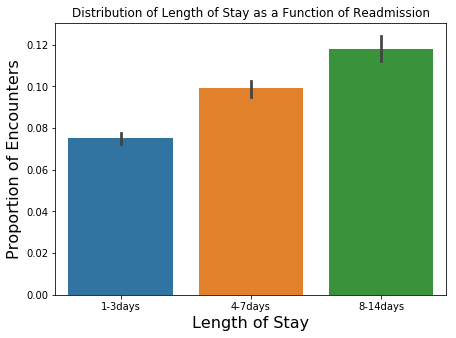

In [11]:
plt.figure(figsize=(7,5))
sns.barplot(data['length_of_stay'], data['readmission']);
plt.title("Distribution of Length of Stay as a Function of Readmission");
plt.ylabel("Proportion of Encounters", size=16);
plt.xlabel("Length of Stay", size=16)
plt.xticks(rotation=0);
plt.savefig('length_of_stay.png')
plt.show()

In [267]:
data[['length_of_stay', 'readmission']].groupby('length_of_stay').describe().T

length_of_stay           1-3days        4-7days      8-14days
readmission count 35135.00000000 25072.00000000 9766.00000000
            mean      0.07513875     0.09911455    0.11796027
            std       0.26361885     0.29882172    0.32257759
            min       0.00000000     0.00000000    0.00000000
            25%       0.00000000     0.00000000    0.00000000
            50%       0.00000000     0.00000000    0.00000000
            75%       0.00000000     0.00000000    0.00000000
            max       1.00000000     1.00000000    1.00000000

#### Number of Procedures (other than lab tests)

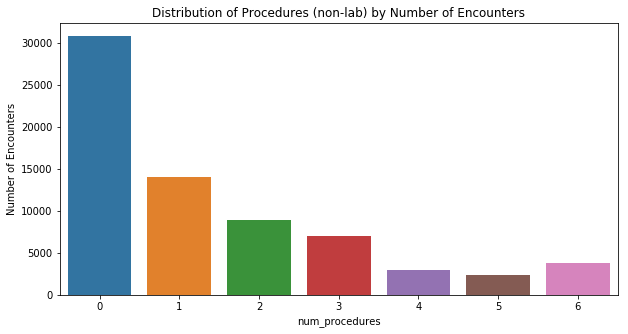

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data['num_procedures'])
plt.title("Distribution of Procedures (non-lab) by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.show()

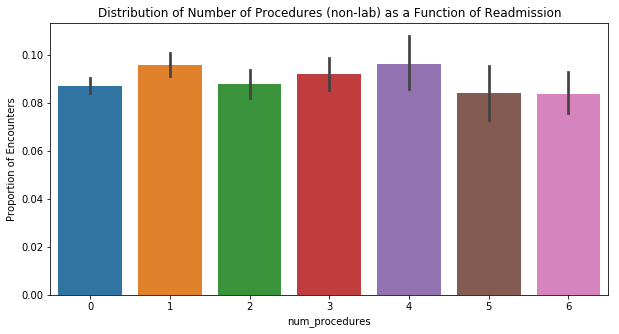

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(data['num_procedures'], data['readmission']);
plt.title("Distribution of Number of Procedures (non-lab) as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

Not clear that this is a separable feature.

#### Number of inpatient visits in the previous year

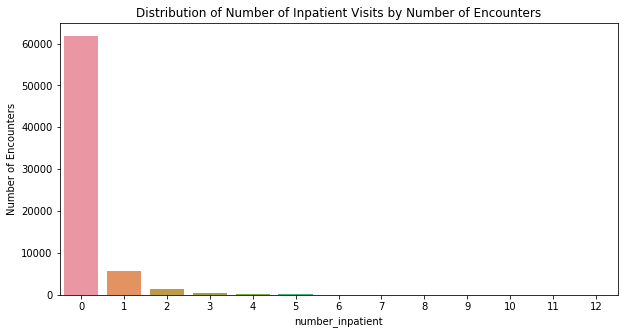

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(data['number_inpatient'])
plt.title("Distribution of Number of Inpatient Visits by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.show()

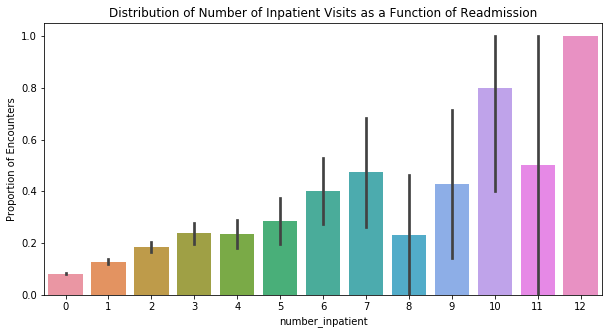

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data['number_inpatient'], data['readmission']);
plt.title("Distribution of Number of Inpatient Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

In [268]:
# Create a new feature that discriminates between an 
# inpatient visit in the past year
data['inpatientInLastYear'] = data['number_inpatient'].apply(lambda s: int(s != 0))

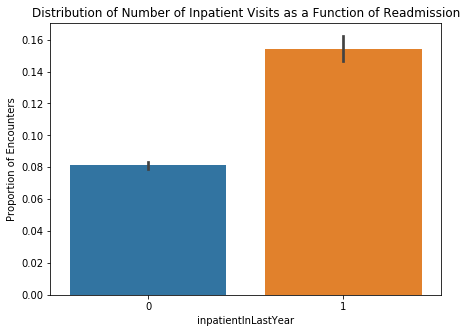

In [14]:
plt.figure(figsize=(7,5))
sns.barplot(data['inpatientInLastYear'], data['readmission']);
plt.title("Distribution of Number of Inpatient Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

#### Number of outpatient visits in the previous year

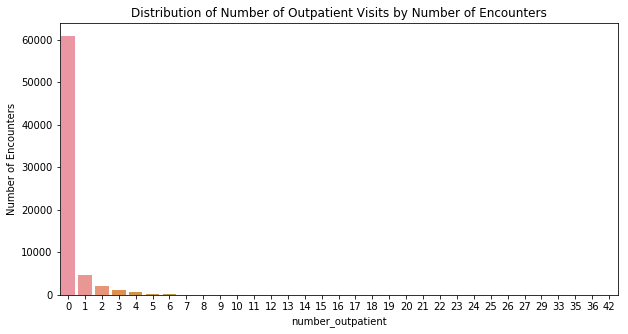

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data['number_outpatient'])
plt.title("Distribution of Number of Outpatient Visits by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.show()

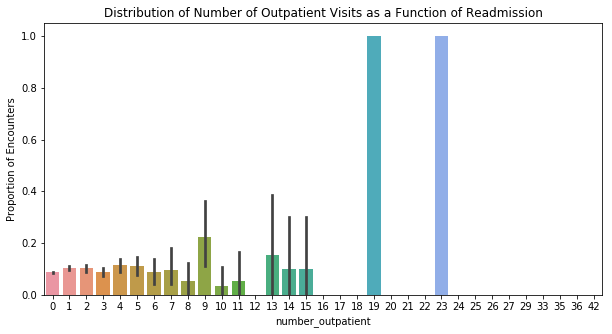

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(data['number_outpatient'], data['readmission']);
plt.title("Distribution of Number of Outpatient Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

In [17]:
# Create a new feature that discriminates 
# between an outpatient visit in the past year
data['outpatientInLastYear'] = data['number_outpatient'].apply(lambda s: int(s != 0))

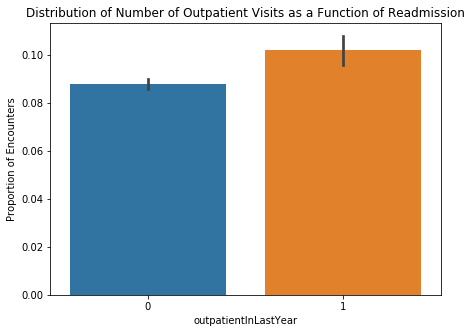

In [18]:
plt.figure(figsize=(7,5))
sns.barplot(data['outpatientInLastYear'], data['readmission']);
plt.title("Distribution of Number of Outpatient Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

#### Number of emergency visits in the previous year

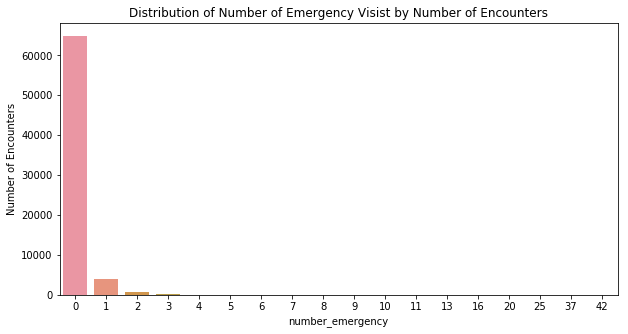

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data['number_emergency'])
plt.title("Distribution of Number of Emergency Visist by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.show()

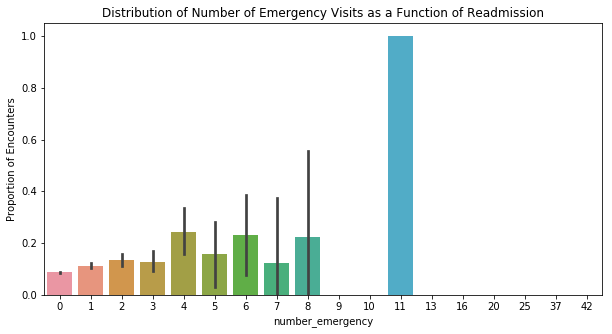

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(data['number_emergency'], data['readmission']);
plt.title("Distribution of Number of Emergency Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

In [21]:
# Create a new feature that discriminates 
# between an emergency visit in the past year
data['emergencyInLastYear'] = data['number_emergency'].apply(lambda s: int(s != 0))

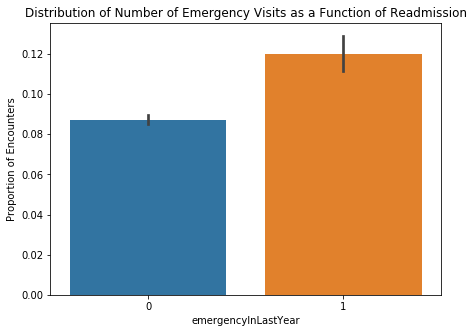

In [22]:
plt.figure(figsize=(7,5))
sns.barplot(data['emergencyInLastYear'], data['readmission']);
plt.title("Distribution of Number of Emergency Visits as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

#### Number of lab tests performed

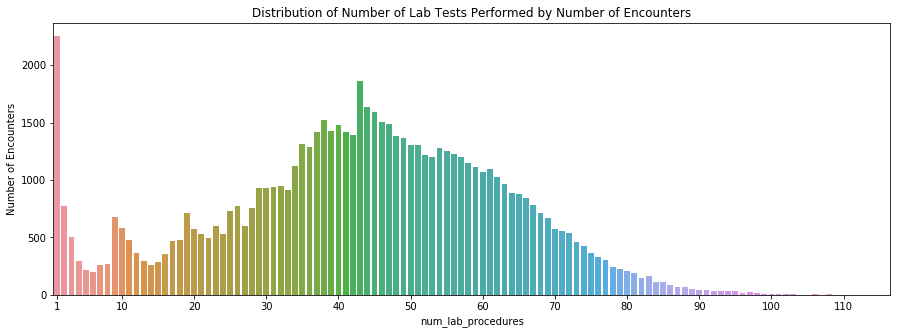

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(data['num_lab_procedures'])
plt.title("Distribution of Number of Lab Tests Performed by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.xticks([0,9,19,29,39,49,59,69,79,89,99,109], 
           [1,10,20,30,40,50,60,70,80,90,100,110])
plt.show()

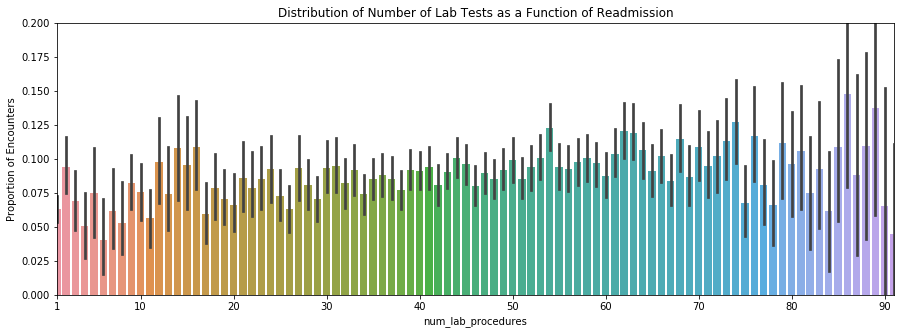

In [24]:
plt.figure(figsize=(15,5))
sns.barplot(data['num_lab_procedures'], data['readmission']);
plt.title("Distribution of Number of Lab Tests as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks([0,9,19,29,39,49,59,69,79,89], 
           [1,10,20,30,40,50,60,70,80,90], rotation=0)
plt.xlim((0,90))
plt.ylim((0,0.2))
plt.show()

This feature does not seem incredibly helpful.

#### Number of diagnoses

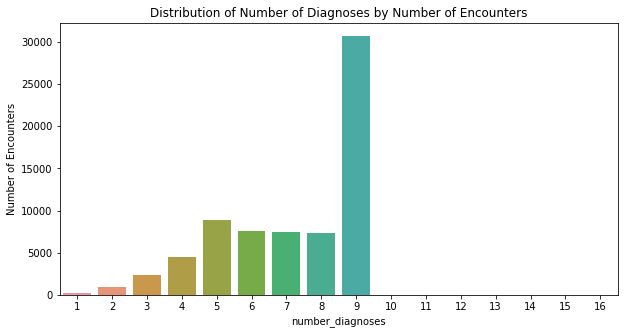

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(data['number_diagnoses'])
plt.title("Distribution of Number of Diagnoses by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.show()

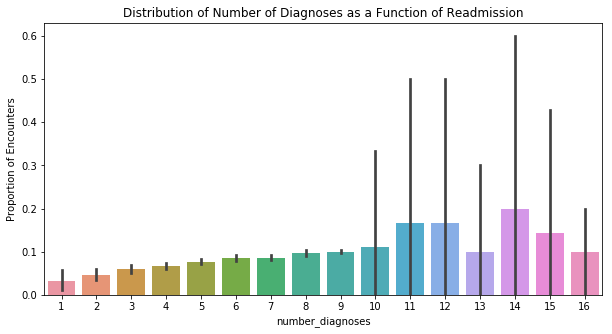

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(data['number_diagnoses'], data['readmission']);
plt.title("Distribution of Number of Diagnoses as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

In [27]:
data['diagnoses'] = data['number_diagnoses'].replace([1,2,3,4], '1-4') \
.replace([5,6,7,8], '5-8') \
.replace([9,10,11,12,13,14,15,16], '9+')

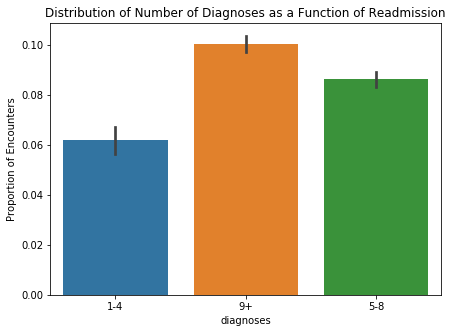

In [28]:
plt.figure(figsize=(7,5))
sns.barplot(data['diagnoses'], data['readmission']);
plt.title("Distribution of Number of Diagnoses as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

#### Number of medications administered

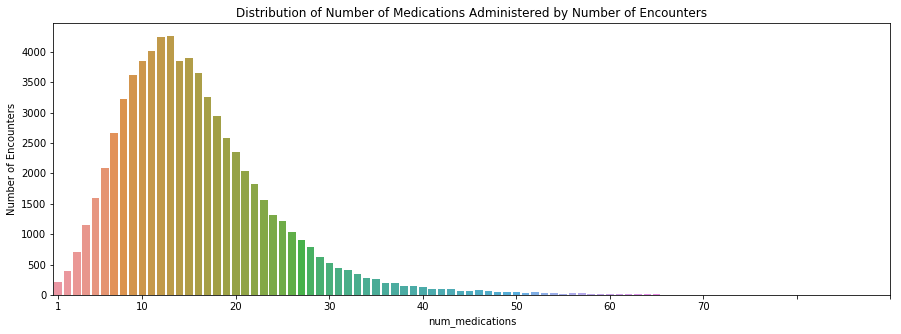

In [29]:
plt.figure(figsize=(15,5))
sns.countplot(data['num_medications'])
plt.title("Distribution of Number of Medications Administered by Number of Encounters");
plt.ylabel("Number of Encounters")
plt.xticks([0,9,19,29,39,49,59,69,79,89], [1,10,20,30,40,50,60,70])
plt.show()

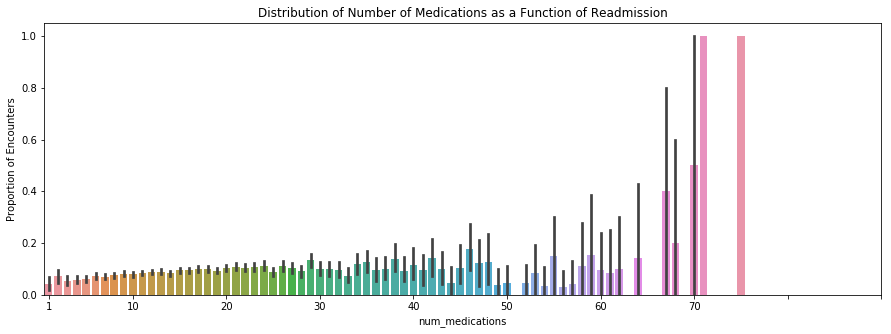

In [30]:
plt.figure(figsize=(15,5))
sns.barplot(data['num_medications'], data['readmission']);
plt.title("Distribution of Number of Medications as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks([0,9,19,29,39,49,59,69,79,89], [1,10,20,30,40,50,60,70])
plt.show()

In [31]:
# Create a new feature for number of medications
def medications_mapping(s):
    
    if(s < 10):
        return('1-9')
    elif(s < 20):
        return('10-19')
    else:
        return('20+')

data['medicationsGiven'] = data['num_medications'].apply(lambda s: medications_mapping(s))

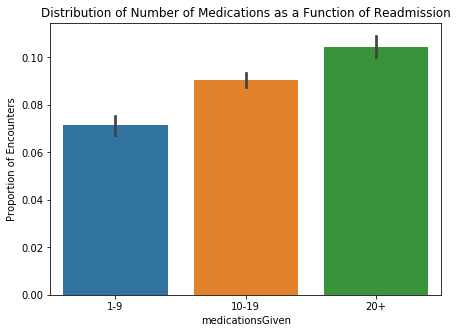

In [32]:
plt.figure(figsize=(7,5))
sns.barplot(data['medicationsGiven'], data['readmission']);
plt.title("Distribution of Number of Medications as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

#### Age

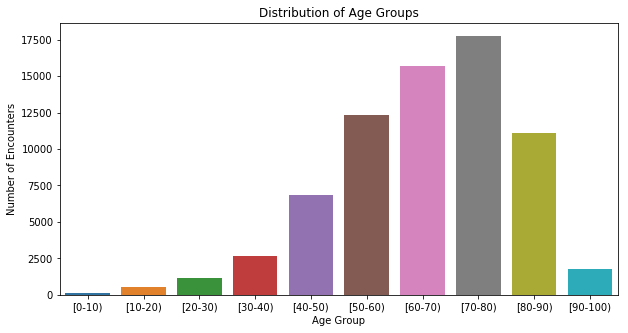

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(data['age'])
plt.title("Distribution of Age Groups");
plt.xlabel("Age Group");
plt.ylabel("Number of Encounters")
plt.show()

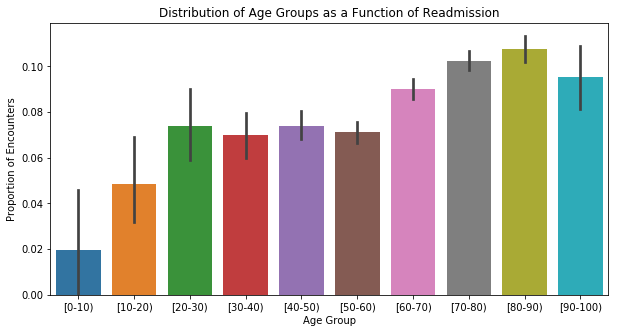

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(data['age'], data['readmission']);
plt.title("Distribution of Age Groups as a Function of Readmission");
plt.xlabel("Age Group");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

Given the distributions above and the described mean statistics for each age group, we can see there are distinct groupings of these groups that could provide a differentiation of the dependent variable. We must be cautious not to create a new feature that collineates with others, so we will create a new **'over59'** feature that can account for the majority age groups.

In [36]:
# Create the 'over59' feature by further grouping the age bins into two distinct groups
data['ageGroup'] = data['age'].map({'[0-10)': 'under20', '[10-20)': 'under20',
                                    '[20-30)': '20-60', '[30-40)': '20-60', 
                                    '[40-50)': '20-60', '[50-60)': '20-60', 
                                    '[60-70)': 'over60', '[70-80)': 'over60',
                                    '[80-90)': 'over60', '[90-100)': 'over60'})

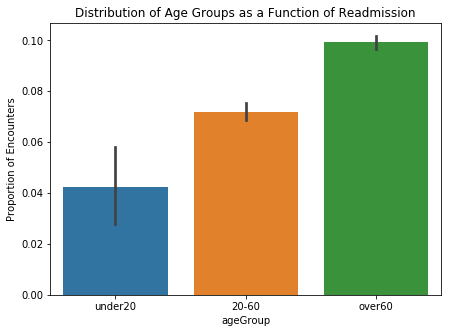

In [37]:
plt.figure(figsize=(7,5))
sns.barplot(data['ageGroup'], data['readmission']);
plt.title("Distribution of Age Groups as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

#### Gender

In [270]:
data[['gender', 'readmission']].groupby('gender').describe().T

gender                    Female           Male  Unknown/Invalid
readmission count 37229.00000000 32741.00000000       3.00000000
            mean      0.09027908     0.08906264       0.00000000
            std       0.28658503     0.28483849       0.00000000
            min       0.00000000     0.00000000       0.00000000
            25%       0.00000000     0.00000000       0.00000000
            50%       0.00000000     0.00000000       0.00000000
            75%       0.00000000     0.00000000       0.00000000
            max       1.00000000     1.00000000       0.00000000

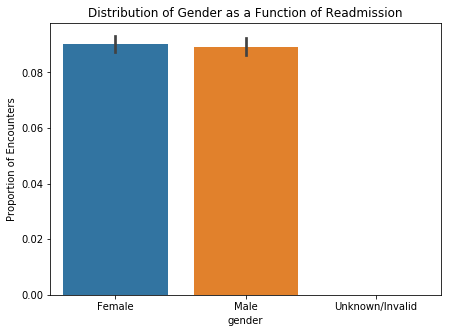

In [39]:
plt.figure(figsize=(7,5))
sns.barplot(data['gender'], data['readmission']);
plt.title("Distribution of Gender as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

Without needing to look at the distribution, it is incredibly clear that 'gender' is not at all a predictive feature.

#### Race

In [271]:
data[['race', 'readmission']].groupby('race').describe().T

race               AfricanAmerican      Caucasian         Other       Unknown
readmission count   12625.00000000 52292.00000000 3138.00000000 1918.00000000
            mean        0.08657426     0.09181137    0.07711918    0.07351408
            std         0.28122130     0.28876225    0.26682298    0.26104652
            min         0.00000000     0.00000000    0.00000000    0.00000000
            25%         0.00000000     0.00000000    0.00000000    0.00000000
            50%         0.00000000     0.00000000    0.00000000    0.00000000
            75%         0.00000000     0.00000000    0.00000000    0.00000000
            max         1.00000000     1.00000000    1.00000000    1.00000000

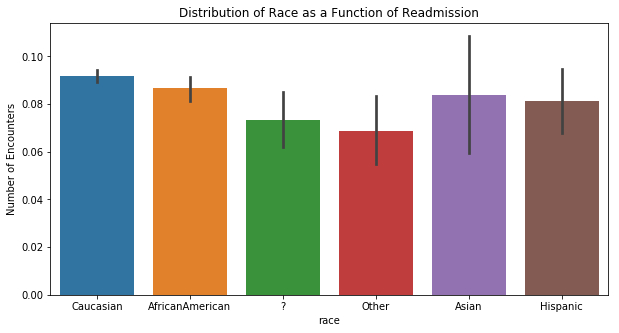

In [41]:
plt.figure(figsize=(10,5))
sns.barplot(data['race'], data['readmission']);
plt.title("Distribution of Race as a Function of Readmission");
plt.ylabel("Number of Encounters");
plt.show()

In [42]:
# Reconfigure the '?' entry into "Unknown"
data['race'] = data['race'].replace(['?'], 'Unknown') \
.replace(['Asian', 'Hispanic'], 'Other')

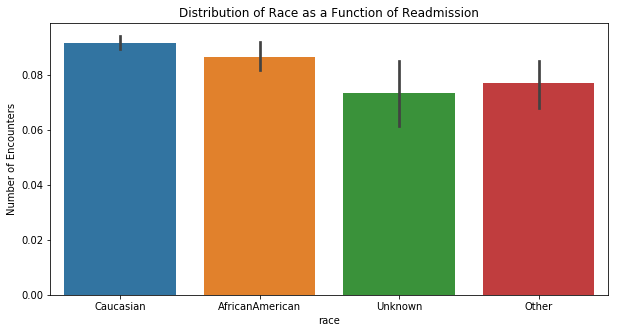

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data['race'], data['readmission']);
plt.title("Distribution of Race as a Function of Readmission");
plt.ylabel("Number of Encounters");
plt.show()

#### Weight

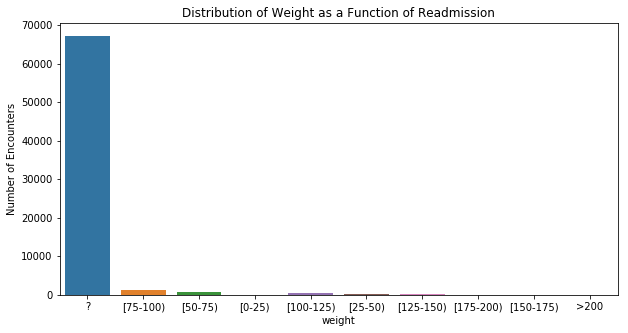

In [44]:
plt.figure(figsize=(10,5))
sns.countplot(data['weight'])
plt.title("Distribution of Weight as a Function of Readmission");
plt.ylabel("Number of Encounters");
plt.show()

From the image above, it's clear that 'weight' as a feature should be dropped. This is because of the fact that prior to the HITECH legislation of the American Reinvestment and Recovery Act in 2009, hospitals and clinics were not required to capture a patient's weight in any particular structured format.

#### Admission Type ID

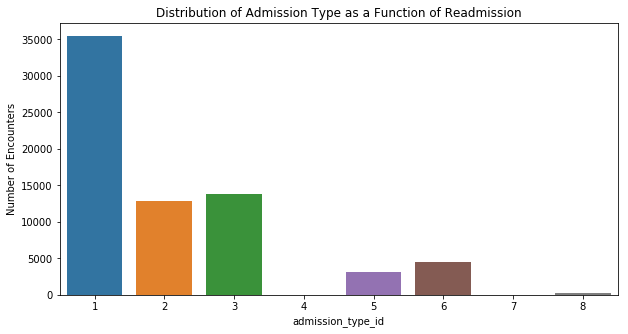

In [46]:
plt.figure(figsize=(10,5))
sns.countplot(data['admission_type_id'])
plt.title("Distribution of Admission Type as a Function of Readmission");
plt.ylabel("Number of Encounters");
plt.show()

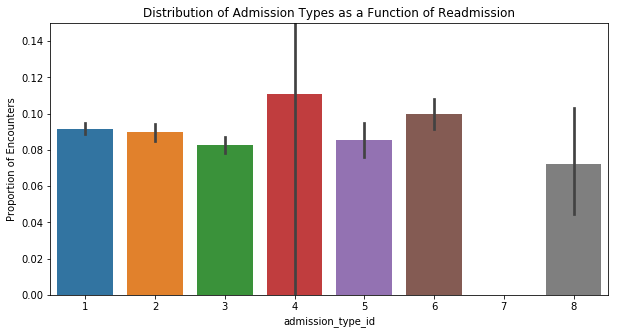

In [47]:
plt.figure(figsize=(10,5))
sns.barplot(data['admission_type_id'], data['readmission']);
plt.title("Distribution of Admission Types as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.ylim((0,0.15))
plt.xticks(rotation=0);
plt.show()

In [48]:
# Create a new feature that corresponds with the types of admission 
# available. Also group the smaller categories into one single category 
# due to lack of information available
data['admission_type'] = data['admission_type_id'].map({1:'Urgent', 2:'Urgent', 3:'Elective',
                                                        4:'Urgent', 5:'Unknown', 6:'Unknown', 
                                                        7:'Urgent', 8:'Unknown'})

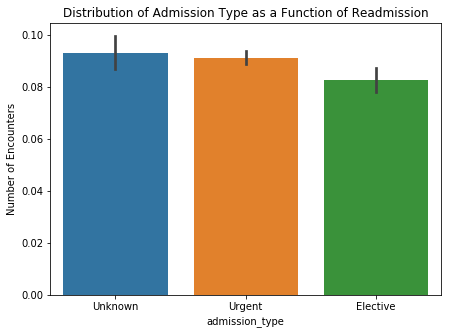

In [49]:
plt.figure(figsize=(7,5))
sns.barplot(data['admission_type'], data['readmission']);
plt.title("Distribution of Admission Type as a Function of Readmission");
plt.ylabel("Number of Encounters");
plt.show()

It does not seem like there will be much predictive power in this feature.

#### discharge_disposition_id

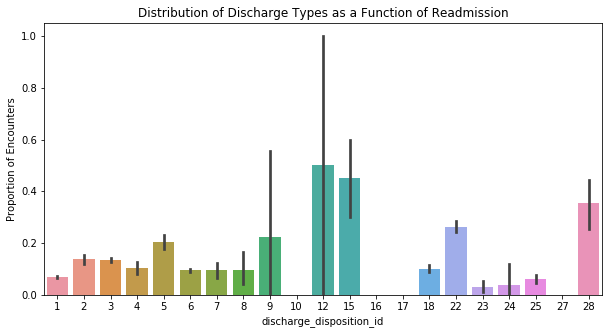

In [51]:
plt.figure(figsize=(10,5))
sns.barplot(data['discharge_disposition_id'], data['readmission']);
plt.title("Distribution of Discharge Types as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

#### Using this data above
There are certainly some categories that apply towards the readmission rate more than others. Disambiguating the discharge codes, the largest code is "Discharged to home" which is '1'. Other large sections that have defined differences in the dependent variable is "Discharged to SNF" '3', "Discharged to additional inpatient care" '5', "Discharged with home care services" '6' and "Discharged to rehab" '22'. We can split this down into 6 categories instead.

In [52]:
# Define a mapping scheme that will create a new feature that remaps the above
def discharge_mapping(s):
    code = int(s)
   
    if code == 1 or code == 6: # Home or Home with visiting nurse
        return "ToHome"
    elif code == 3:
        return "ToSNF"
    elif code == 5:
        return "Inpatient"
    elif code == 22:
        return "Rehab"
    else:
        return "Other"

In [53]:
data['discharge_disposition'] = data['discharge_disposition_id'].map(lambda x: discharge_mapping(x))

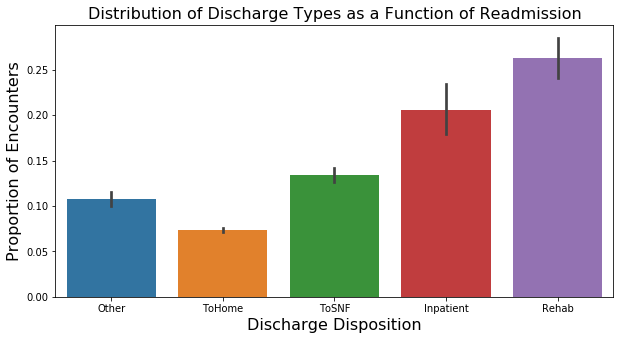

In [244]:
plt.figure(figsize=(10,5))
sns.barplot(data['discharge_disposition'], data['readmission']);
plt.title("Distribution of Discharge Types as a Function of Readmission", size=16);
plt.ylabel("Proportion of Encounters", size=16);
plt.xlabel("Discharge Disposition", size=16)
plt.xticks(rotation=0);
plt.savefig('discharge.png')
plt.show()

Definitely looks like these discharge dispositions will play a role in predictive power of the dependent variable

#### Admission Source ID

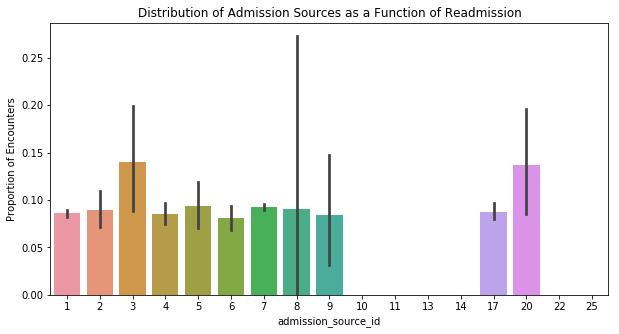

In [56]:
plt.figure(figsize=(10,5))
sns.barplot(data['admission_source_id'], data['readmission']);
plt.title("Distribution of Admission Sources as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

Using the data above, it is hard to consider that there is variability in the different admission sources enough so that we can have predictive power in the dependent variable. However, for sake of completeness, we will merge down the categories into more understandable bins and see if we come up with anything.

In [57]:
# Define a mapping scheme that will create a new feature that remaps the above
def admission_mapping(s):
    code = int(s)
   
    if code == 1 or code == 2 or code == 3:
        return "Referral"
    elif code == 4 or code == 5 or code == 6 or code == 18:
        return "Transfer"
    elif code == 7:
        return "Urgent"
    elif code == 9 or code == 15 or code == 17 or code == 20 or code == 21:
        return "Unknown"
    else:
        return "Other"

In [58]:
data['admission_source'] = data['admission_source_id'].map(lambda x: admission_mapping(x))

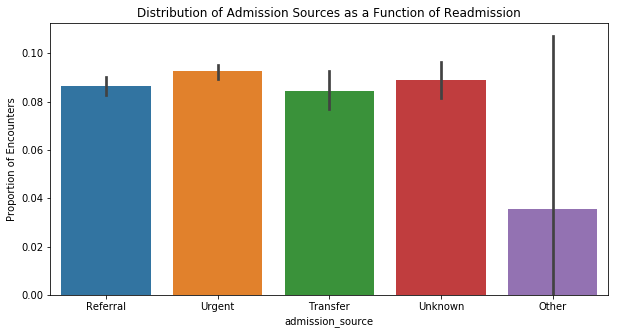

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(data['admission_source'], data['readmission']);
plt.title("Distribution of Admission Sources as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

It is highly unlikely admission source will play any role in our predictions

#### Medical Specialty

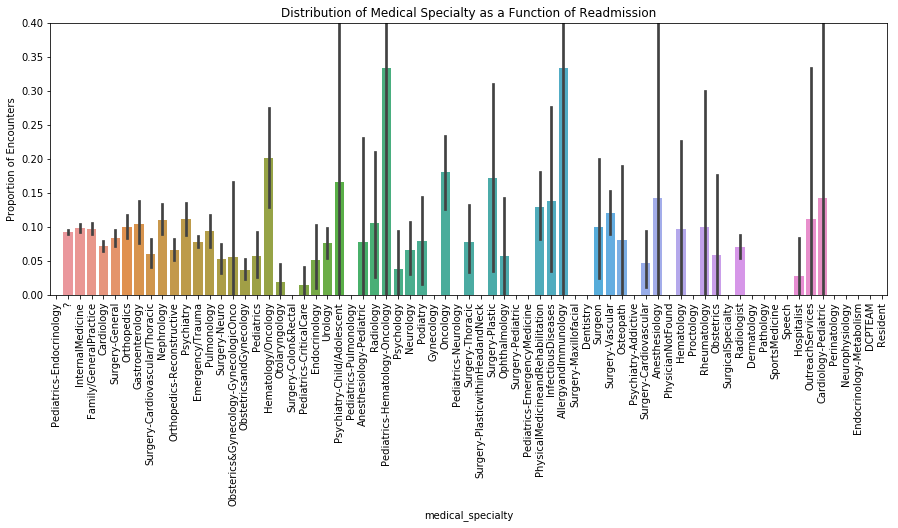

In [61]:
plt.figure(figsize=(15,5))
sns.barplot(data['medical_specialty'], data['readmission']);
plt.title("Distribution of Medical Specialty as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.ylim((0,0.4))
plt.xticks(rotation=90);
plt.show()

There may be some latent predictive power in what we see here, particularly if we group certain types of medical specialties together.

In [62]:
# Define a mapping scheme that will create a new feature that remaps the above
def specialty_mapping(s):
    code = str(s)
    
    if code == "Cardiology" or code == "Cardiology-Pediatric":
        return "Cardiology"
    elif code == "Emergency/Trauma":
        return "Emergency"
    elif code == "Family/GeneralPractice":
        return "General"
    elif code == "InternalMedicine":
        return "Internal"
    elif code == "Urology":
        return "Urology"
    elif code == "Nephrology":
        return "Nephrology"
    elif code == "Otolaryngology":
        return "Otolaryngology"
    elif code == "Oncology":
        return "Oncology"
    elif code == "Pulmonology":
        return "Pulmonology"
    elif re.match(r"Surg", code):
        return "Surgery"
    elif re.match(r"Pediatric", code):
        return "Pediatrics"
    elif re.match(r"Endocrinology", code):
        return "Endocrinology"
    elif re.match(r"Orthopedics", code):
        return "Orthopedics"
    elif re.match(r"Psychiatry", code):
        return "Psychiatry"
    elif re.match(r"Radiolo", code):
        return "Radiology"
    elif re.match(r"Neuro", code):
        return "Neurology"
    elif re.match(r"Obstetrics", code) or re.match(r"Gynecology", code):
        return "Obstetrics"
    elif code == "?" or code == "PhysicianNotFound":
        return "Unknown"
    else:
        return "Other"
    
data['specialty'] = data['medical_specialty'].map(lambda x: specialty_mapping(x))

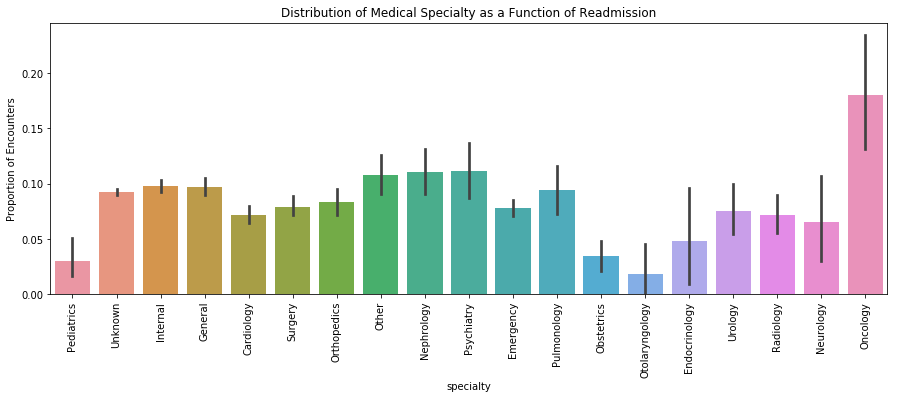

In [64]:
plt.figure(figsize=(15,5))
sns.barplot(data['specialty'], data['readmission']);
plt.title("Distribution of Medical Specialty as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=90);
plt.show()

It is possible that medical specialty may not play a significant enough role in predicting the dependent variable, however, "Unknown" speciality dominates the dataset and may cause issues.

#### Max GLU Serum and A1C Result Tests

In [273]:
data[['max_glu_serum', 'readmission']].groupby('max_glu_serum').describe().T

max_glu_serum             >200         >300           None          Norm
readmission count 936.00000000 712.00000000 66625.00000000 1700.00000000
            mean    0.10897436   0.10112360     0.08911069    0.09764706
            std     0.31177363   0.30170426     0.28490559    0.29692419
            min     0.00000000   0.00000000     0.00000000    0.00000000
            25%     0.00000000   0.00000000     0.00000000    0.00000000
            50%     0.00000000   0.00000000     0.00000000    0.00000000
            75%     0.00000000   0.00000000     0.00000000    0.00000000
            max     1.00000000   1.00000000     1.00000000    1.00000000

In [66]:
# Create a feature for whether the test was administered or not
data['GLUtested'] = data['max_glu_serum'].map({'>200':1, '>300':1, 'Norm':1, 'None':0})

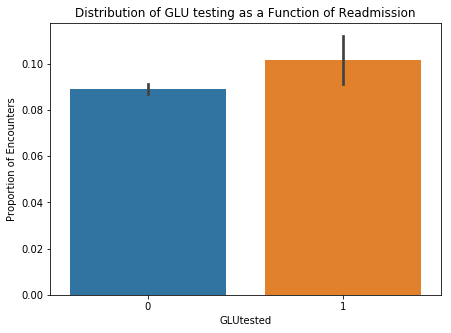

In [67]:
plt.figure(figsize=(7,5))
sns.barplot(data['GLUtested'], data['readmission']);
plt.title("Distribution of GLU testing as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

In [274]:
data[['A1Cresult', 'readmission']].groupby('A1Cresult').describe().T

A1Cresult                    >7            >8           None          Norm
readmission count 2865.00000000 6239.00000000 57128.00000000 3741.00000000
            mean     0.08586387    0.08158359     0.09100616    0.08634055
            std      0.28021184    0.27375120     0.28762039    0.28090381
            min      0.00000000    0.00000000     0.00000000    0.00000000
            25%      0.00000000    0.00000000     0.00000000    0.00000000
            50%      0.00000000    0.00000000     0.00000000    0.00000000
            75%      0.00000000    0.00000000     0.00000000    0.00000000
            max      1.00000000    1.00000000     1.00000000    1.00000000

In [69]:
# Create a feature for whether the test was administered or not
data['A1Ctested'] = data['A1Cresult'].map({'>7':1, '>8':1, 'Norm':1, 'None':0})

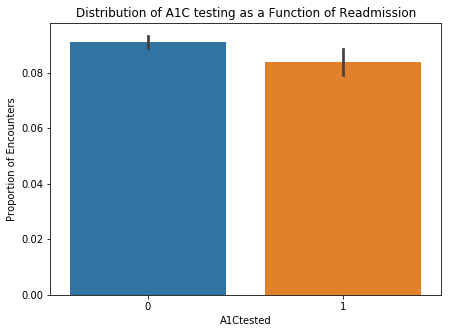

In [70]:
plt.figure(figsize=(7,5))
sns.barplot(data['A1Ctested'], data['readmission']);
plt.title("Distribution of A1C testing as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

#### Medications
**Note:** In the paper, 'sitagliptin' is mentioned to be one of the medications that data is drawn from. However, this feature is not present in the data. In addition, there are four medications given that do not have distinguishible entries; i.e., 'citoglipton', 'examide', 'metformin-pioglitazone' and 'glimepiride-pioglitazone' are not recorded for any patient as being a medication used in treatment. Because these features do not give any additional information, we can remove them without any loss.

In [71]:
medications_keep = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                    'miglitol', 'troglitazone', 'tolazamide',  'insulin', 
                    'glyburide-metformin', 'glipizide-metformin',
                    'metformin-rosiglitazone']

medications_toss = ['examide', 'citoglipton', 'glimepiride-pioglitazone', 
                    'metformin-pioglitazone']

In [275]:
# Example showing the lack of information for some medications
data[['glimepiride-pioglitazone', 'readmission']].groupby('glimepiride-pioglitazone').describe().T

glimepiride-pioglitazone             No
readmission count        69973.00000000
            mean             0.08970603
            std              0.28576218
            min              0.00000000
            25%              0.00000000
            50%              0.00000000
            75%              0.00000000
            max              1.00000000

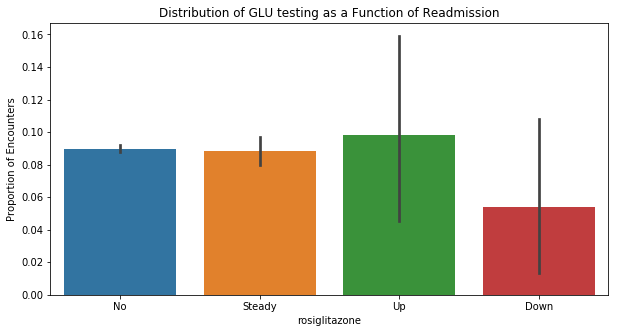

In [73]:
plt.figure(figsize=(10,5))
sns.barplot(data['rosiglitazone'], data['readmission']);
plt.title("Distribution of GLU testing as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.show()

In [276]:
data[['diabetesMed', 'readmission']].groupby('diabetesMed').describe().T

diabetesMed                   No            Yes
readmission count 16680.00000000 53293.00000000
            mean      0.07547962     0.09415871
            std       0.26417159     0.29205213
            min       0.00000000     0.00000000
            25%       0.00000000     0.00000000
            50%       0.00000000     0.00000000
            75%       0.00000000     0.00000000
            max       1.00000000     1.00000000

In [277]:
data[['change', 'readmission']].groupby('change').describe().T

change                        Ch             No
readmission count 31491.00000000 38482.00000000
            mean      0.09434442     0.08591030
            std       0.29231192     0.28023518
            min       0.00000000     0.00000000
            25%       0.00000000     0.00000000
            50%       0.00000000     0.00000000
            75%       0.00000000     0.00000000
            max       1.00000000     1.00000000

In [76]:
# Create new features that relate to the the number of medications and their changes (if applicable)
data['meds_steady'] = data[medications_keep].apply(lambda s: int((s == "Steady").sum() > 0), axis=1)
data['meds_increased'] = data[medications_keep].apply(lambda s: int((s == "Down").sum() > 0), axis=1)
data['meds_decreased'] = data[medications_keep].apply(lambda s: int((s == "Up").sum() > 0), axis=1)

In [77]:
# Create features that map the categories into values {0,1}
data['medChange'] = data['change'].replace(['No', 'Ch'], [0, 1])
data['medDiabetes'] = data['diabetesMed'].replace(['No', 'Yes'], [0, 1])

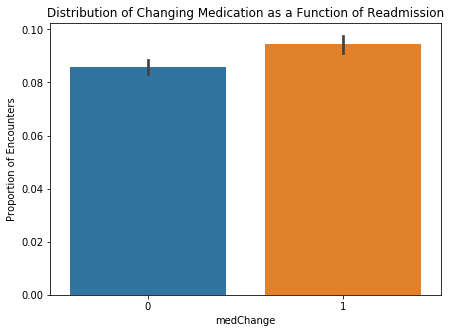

In [78]:
plt.figure(figsize=(7,5))
sns.barplot(data['medChange'], data['readmission']);
plt.title("Distribution of Changing Medication as a Function of Readmission");
plt.ylabel("Proportion of Encounters");
plt.xticks(rotation=0);
plt.show()

In [79]:
# Create medication features that simply describe whether the patient is 
# taking or not taking that particular medication
for m in medications_keep:
    data['prescribed_' + m] = data[m].replace(['No', 'Up', 'Down', 'Steady'], [0, 1, 1, 1])

### Adjusting ICD-9 Codes Present in Diagnoses

In the features 'diag_1', 'diag_2', and 'diag_3', the patient is recorded with an icd-9 code, which has many different options. In the functionality below, we attempt to disambiguate these codes into major classes of diagnoses. These codes can be found here: https://en.wikipedia.org/wiki/List_of_ICD-9_codes 

In [80]:
# Define a mapping that will disambiguate the icd-9 codes
def icd9_mapping(s):
    codegroup = ""
    
    # Some codes use the letters E-V, which is not a number.
    try:
        code = int(float(s))
    except:
        if(s == "?"):
            code = np.nan
        else:
            code = 0
    
    if (code >= 1 and code <= 139):
        codegroup = "Infectious"
    
    elif (code >= 140 and code <= 239):
        codegroup = "Neoplasms"
    
    elif (code >= 240 and code <= 279 and code != 250): # Diabetic is code 250.xx
        codegroup = "Endocrine"
        
    elif (code == 250):
        codegroup = "Diabetic"
    
    elif (code >= 280 and code <= 289):
        codegroup = "BloodOrgans"
        
    elif (code >= 290 and code <= 319):
        codegroup = "MentalDisorder"
        
    elif (code >= 320 and code <= 389) or (code == 781):
        codegroup = "NervousSystem"
    
    elif (code >= 390 and code <= 459) or (code == 785):
        codegroup = "Circulatory"
    
    elif (code >= 460 and code <= 519) or (code == 786):
        codegroup = "Respiratory"
    
    elif (code >= 520 and code <= 579) or (code == 787):
        codegroup = "Digestive"
    
    elif (code >= 580 and code <= 629) or (code == 788):
        codegroup = "Genitourinary"
    
    elif (code >= 630 and code <= 679):
        codegroup = "Pregnancy"
        
    elif (code >= 680 and code <= 709) or (code == 782):
        codegroup = "Skin"
        
    elif (code >= 710 and code <= 739):
        codegroup = "Musculoskeletal"
        
    elif (code >= 740 and code <= 759):
        codegroup = "Congenital"
        
    elif (code >= 760 and code <= 779):
        codegroup = "Perinatal"
        
    elif (code >= 790 and code <= 799) or (code == 780):
        codegroup = "Symptomatic"
        
    elif (code >= 800 and code <= 999):
        codegroup = "Injury"
    
    elif (code == 0):
        codegroup = "ExternalCauses"
    
    else:
        codegroup = "None"
        
    return codegroup

In [81]:
# We now create three new diagnoses features that correspond with this mapping
data['major_diagnosis'] = data['diag_1'].apply(lambda s: icd9_mapping(s))
data['secondary_diagnosis'] = data['diag_2'].apply(lambda s: icd9_mapping(s))
data['tertiary_diagnosis'] = data['diag_3'].apply(lambda s: icd9_mapping(s))

We can now visualize the diagnoses as a function of the readmission rate.

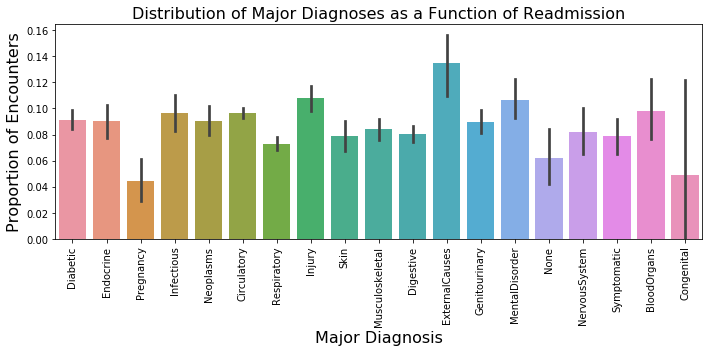

In [172]:
plt.figure(figsize=(10,5))
sns.barplot(data['major_diagnosis'], data['readmission']);
plt.title("Distribution of Major Diagnoses as a Function of Readmission", size=16);
plt.ylabel("Proportion of Encounters", size=16);
plt.xlabel("Major Diagnosis", size=16);
plt.xticks(rotation=90);
plt.tight_layout()
plt.savefig('majordiag.png')
plt.show()

## Create dummy features
For the features that are categorical, we must create dummy features that correspond to those features in a category-by-category basis.

In [83]:
# Collect the features that are categorical and need to be represented by dummies
cat_features = ['admission_source', 'admission_type', 'discharge_disposition', 
                'specialty', 'major_diagnosis', 'secondary_diagnosis', 
                'tertiary_diagnosis', 'ageGroup', 'length_of_stay', 
                'medicationsGiven', 'diagnoses']

# Create the dummies DataFrame using 'race' as the first categorical feature
dummies = pd.get_dummies(data['race'], prefix='race', drop_first=False)

# All other categorical features
for feature in cat_features:
    dummies = dummies.join(pd.get_dummies(data[feature], prefix=feature, drop_first=False))

#### Data Cleaning
We now create a new DataFrame that contains only the features we're interested in from the above engineering. We will drop several features that play no role in predictive outcomes, and also remove features that remain from the creation of the dummy features above.

In [287]:
# Create the new DataFrame from necessary features
cleanData = (data.drop(['patient_nbr', 'encounter_id', 'payer_code', 'weight',
                        'gender', 'num_lab_procedures', 'num_procedures', 
                        'admission_type', 'admission_source', 'discharge_disposition',
                        'specialty', 'admission_source_id','admission_type_id', 
                        'discharge_disposition_id','medical_specialty', 'max_glu_serum', 
                        'A1Cresult', 'change', 'diabetesMed', 'race', 'age', 'diag_1',
                        'diag_2', 'diag_3', 'major_diagnosis', 'secondary_diagnosis', 
                        'tertiary_diagnosis', 'readmitted', 'number_inpatient', 
                        'number_outpatient', 'number_emergency', 'num_medications', 
                        'time_in_hospital', 'number_diagnoses', 'medicationsGiven',
                        'ageGroup', 'length_of_stay', 'diagnoses'
                        ] + medications_keep + medications_toss, axis=1)).join(dummies)

# Display the new dummy features
print(cleanData.shape)
for column in cleanData.columns:
    print(column)

(69973, 135)
readmission
inpatientInLastYear
outpatientInLastYear
emergencyInLastYear
GLUtested
A1Ctested
meds_steady
meds_increased
meds_decreased
medChange
medDiabetes
prescribed_metformin
prescribed_repaglinide
prescribed_nateglinide
prescribed_chlorpropamide
prescribed_glimepiride
prescribed_acetohexamide
prescribed_glipizide
prescribed_glyburide
prescribed_tolbutamide
prescribed_pioglitazone
prescribed_rosiglitazone
prescribed_acarbose
prescribed_miglitol
prescribed_troglitazone
prescribed_tolazamide
prescribed_insulin
prescribed_glyburide-metformin
prescribed_glipizide-metformin
prescribed_metformin-rosiglitazone
race_AfricanAmerican
race_Caucasian
race_Other
race_Unknown
admission_source_Other
admission_source_Referral
admission_source_Transfer
admission_source_Unknown
admission_source_Urgent
admission_type_Elective
admission_type_Unknown
admission_type_Urgent
discharge_disposition_Inpatient
discharge_disposition_Other
discharge_disposition_Rehab
discharge_disposition_ToHome
dis

# Feature Reductions

#### Create the test and training sets

In [85]:
# Separate the features from the dependent variable 'readmission'
X = cleanData.drop('readmission', axis=1)
y = cleanData.readmission

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                    random_state=42, stratify=y)
X_train.shape

(62975, 134)

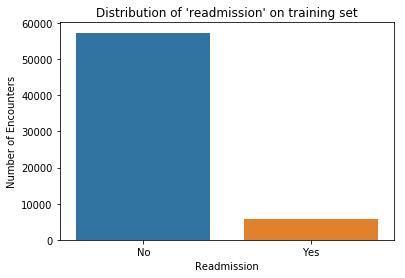

In [86]:
sns.countplot(y_train);
plt.title("Distribution of 'readmission' on training set");
plt.xlabel("Readmission");
plt.xticks([0,1], ['No','Yes'])
plt.ylabel("Number of Encounters");

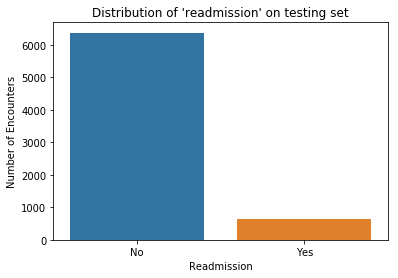

In [87]:
sns.countplot(y_test);
plt.title("Distribution of 'readmission' on testing set");
plt.xlabel("Readmission");
plt.xticks([0,1], ['No','Yes'])
plt.ylabel("Number of Encounters");

In [247]:
y_test.value_counts()

0    6370
1     628
Name: readmission, dtype: int64

## Feature reduction
We reduce the number of features by considering whether the two sample distributions of each feature with respect to the dependent variable are statistically independent by assuming a pvalue of less than 0.001 as **statistically significant**.

In [237]:
# Collect the pvalues of the two-sample z-test for population means
pvalue = []
for feature in X_train.columns:
    sm = ztest(X_train[feature][y_train == 1].ravel(),
               X_train[feature][y_train == 0].ravel())
    pvalue.append(sm[1])

# Collect all features into a DataFrame with their p-values given
feature_significance = pd.DataFrame({'pvalue': pvalue}, index=X_train.columns)

# Get the features that are statistically significant
p_critical = 0.001
X_train_significant = X_train[feature_significance[feature_significance['pvalue'] < p_critical].index]
X_test_significant = X_test[feature_significance[feature_significance['pvalue'] < p_critical].index]

# Print number of remaning features
print("Remaining number of statistically significant features: {}".format(len(X_test_significant.columns)))

feature_significance.sort_values('pvalue', axis=0)

Remaining number of statistically significant features: 37


,pvalue
discharge_disposition_ToHome,0.00000000
discharge_disposition_Rehab,0.00000000
inpatientInLastYear,0.00000000
discharge_disposition_ToSNF,0.00000000
length_of_stay_1-3days,0.00000000
discharge_disposition_Inpatient,0.00000000
ageGroup_over60,0.00000000
ageGroup_20-60,0.00000000
length_of_stay_8-14days,0.00000000
diagnoses_1-4,0.00000000


## Begin initial testing on the training set

In [89]:
# Create a weighted f1 scorer and cross-validation folds for intial testing
f1_scorer = make_scorer(f1_score, average='weighted')
cv = StratifiedKFold(n_splits=3, random_state=0)

### Upsample the dataset using SMOTE
Here, we upsample the minority class using SMOTE (Synthetic Minority Over-sampling Technique), which is a way of creating synthetic data as opposed to simply resampling the dataset and having identically duplicated entries. This is necessary for the Multi-Layer Perceptron classifier, as without it, it will incorrectly learn a favoritism between the imbalanced dataset.

In [90]:
# Create synthetic data for the multi-layer perceptron using random oversampling 
# if the minority class to rebalance the classes in the training set
sm = RandomOverSampler(random_state=42)

X_train_os, y_train_os = sm.fit_resample(X_train_significant, y_train)

X_train_os = pd.DataFrame(data=X_train_os, columns=X_train_significant.columns).astype(int)
y_train_os = pd.DataFrame(data=y_train_os, columns=['readmission']).readmission

#### Logistic Regression default testing

In [91]:
# Logistic Regression Classifier
LRC = LogisticRegression(class_weight='balanced', random_state=0, solver='lbfgs')
LRC_score = cross_val_score(LRC, X_train_significant, y_train, cv=cv, scoring=f1_scorer)

for i, fold in enumerate(LRC_score):
    print("Weighted F1-Score on fold k={}: {:.4f}".format(i, fold))
print("Weighted Average F1-Score of model: {:.4f}".format(LRC_score.sum()/(i+1)))

Weighted F1-Score on fold k=0: 0.7341
Weighted F1-Score on fold k=1: 0.7301
Weighted F1-Score on fold k=2: 0.7315
Weighted Average F1-Score of model: 0.7319


#### Neural Network default testing

In [93]:
# Neural Network Untrained
MLPC = MLPClassifier(random_state=0)
MLPC_score = cross_val_score(MLPC, X_train_os, y_train_os, cv=cv, scoring=f1_scorer)

for i, fold in enumerate(MLPC_score):
    print("Weighted F1-Score on fold k={}: {:.4f}".format(i, fold))
print("Weighted Average F1-Score of model: {:.4f}".format(MLPC_score.sum()/(i+1)))

Weighted F1-Score on fold k=0: 0.6870%
Weighted F1-Score on fold k=1: 0.6892%
Weighted F1-Score on fold k=2: 0.6864%
Weighted Average F1-Score of model: 0.6875%


### Parameter Visualization
Visualize the inverse regularization parameter 'C' as a function of the Weighted Average F1-Score for the Logistic Regression Classifier.

In [94]:
# Check the cross-validation scores as a function of the regularization parameter
param_range = np.logspace(-5, 0, 6)

train_scores, test_scores = validation_curve(
    LogisticRegression(random_state=0, class_weight='balanced', solver='lbfgs'), 
    X_train_significant, y_train, param_name="C", param_range=param_range, 
    cv=cv, scoring=f1_scorer, n_jobs=-1)

In [1]:
# Draw the validation curves
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.title("Validation Curve with Logistic Regression", size=20)
plt.xlabel("Inverse Regularization Parameter 'C'", size=16)
plt.ylabel("Weighted Average F1-Score", size=16)
plt.ylim(0.65, 0.75)
plt.xlim(10E-6,1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

NameError: name 'np' is not defined

### Model Optimization
Perform Grid Search on both a parameterized Logistic Regression Classifier model and a Multi-Layer Perceptron Classifier model.

#### Logistic Regression: optimize the regularization parameter 

In [96]:
# Perform GridSearch
LRC_grid_search = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced', 
                                                  solver='lbfgs'), {'C': param_range}, cv=cv, 
                               scoring=f1_scorer, return_train_score=True, n_jobs=-1)

# Get the best model 
LRC_model = LRC_grid_search.fit(X_train_significant, y_train)

# Get probabilities of each prediction for the positive class
y_proba_LRC = LRC_model.predict_proba(X_test_significant)[:,1]

# Get the prediction for each test item using the default threshold (0.5)
y_preds_LRC = LRC_model.predict(X_test_significant)

# Show the parameter C
print("Optimal model parameter 'C': {}".format(LRC_model.best_params_['C']))

# Show the weighted f1-score on the testing set
print("Weighted F1-Score on the testing set: {:.4f}".format(f1_score(y_test, 
                                                                     y_preds_LRC, 
                                                                     average='weighted')))

Optimal model parameter 'C': 1.0
Weighted F1-Score on the testing set: 0.7325


#### Multi-Layer Perceptron Classifier: optimize the learning rate

In [97]:
# Perform GridSearch
MLPC_grid_search = GridSearchCV(MLPClassifier(random_state=0, hidden_layer_sizes=(30,)), 
                                {'alpha': np.logspace(-5,1,7)}, cv=cv, scoring=f1_scorer, 
                                return_train_score=True, n_jobs=-1)

# Get the best model 
MLPC_model = MLPC_grid_search.fit(X_train_os, y_train_os)

# Get probabilities of each prediction for the positive class
y_proba_MLPC = MLPC_model.predict_proba(X_test_significant)[:,1]

# Get the prediction for each test item using the default threshold (0.5)
y_preds_MLPC = MLPC_model.predict(X_test_significant)

# Show the parameter alpha
print("Optimal alpha: {}".format(MLPC_model.best_params_['alpha']))

# Show the weighted f1-score on the testing set
print("Weighted F1-Score on the testing set: {:.4f}".format(f1_score(y_test, 
                                                                     y_preds_MLPC, 
                                                                     average='weighted')))

Optimal alpha: 0.001
Weighted F1-Score on the testing set: 0.7539


### ROC Curve with AUROC Score

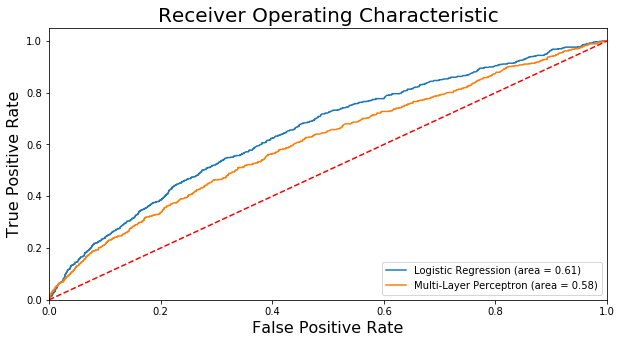

In [106]:
MLPC_fpr, MLPC_tpr, MLPC_threshold = roc_curve(y_test, y_proba_MLPC)
LRC_fpr, LRC_tpr, LRC_threshold = roc_curve(y_test, y_proba_LRC)

# Plotting
plt.figure(figsize=(10,5))
plt.plot(LRC_fpr, LRC_tpr, label='Logistic Regression (area = %0.2f)' 
         % roc_auc_score(y_test, y_preds_LRC))
plt.plot(MLPC_fpr, MLPC_tpr, label='Multi-Layer Perceptron (area = %0.2f)' 
         % roc_auc_score(y_test, y_preds_MLPC))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.title('Receiver Operating Characteristic', size=20)
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()

### Confusion Matrices

#### Logistic Regression Classifier

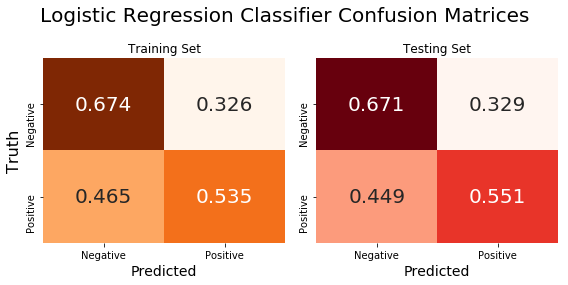

In [262]:
f, axes = plt.subplots(1,2, figsize=(8,4))

LRC_train_cm = confusion_matrix(y_train, LRC_model.best_estimator_.predict(X_train_significant))
LRC_train_cm = LRC_train_cm.astype('float') / LRC_train_cm.sum(axis=1)[:, np.newaxis]

LRC_test_cm  = confusion_matrix(y_test, y_preds_LRC)
LRC_test_cm = LRC_test_cm.astype('float') / LRC_test_cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(pd.DataFrame(LRC_train_cm, columns=['Negative', 'Positive'], 
                         index=['Negative', 'Positive']), annot=True, fmt='.3f', cbar=False, 
            cmap="Oranges", annot_kws={"size": 20}, ax=axes[0]);

sns.heatmap(pd.DataFrame(LRC_test_cm, columns=['Negative', 'Positive'],
                         index=['Negative', 'Positive']), annot=True, fmt='.3f', cbar=False, 
            cmap="Reds", annot_kws={"size": 20}, ax=axes[1]);

f.suptitle("Logistic Regression Classifier Confusion Matrices", size=20)

axes[0].set_title("Training Set")
axes[0].set_xlabel("Predicted", size=14)
axes[0].set_ylabel("Truth", size=16)
axes[1].set_title("Testing Set")
axes[1].set_xlabel("Predicted", size=14)
plt.tight_layout()
f.subplots_adjust(top=0.80)
plt.savefig('cm1.png')

#### Multi-Layer Perceptron Classifier

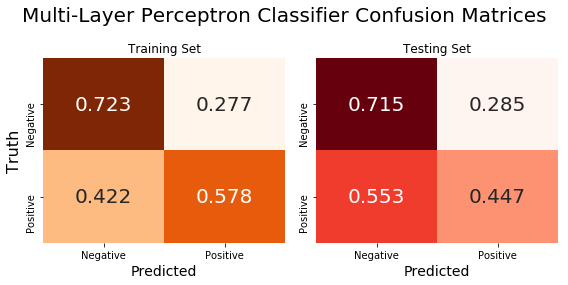

In [263]:
f, axes = plt.subplots(1,2, figsize=(8,4))

MLPC_train_cm = confusion_matrix(y_train_os, MLPC_model.best_estimator_.predict(X_train_os))
MLPC_train_cm = MLPC_train_cm.astype('float') / MLPC_train_cm.sum(axis=1)[:, np.newaxis]

MLPC_test_cm  = confusion_matrix(y_test, y_preds_MLPC)
MLPC_test_cm = MLPC_test_cm.astype('float') / MLPC_test_cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(pd.DataFrame(MLPC_train_cm, columns=['Negative', 'Positive'], 
                         index=['Negative', 'Positive']), annot=True, fmt='.3f', cbar=False, 
            cmap="Oranges", annot_kws={"size": 20}, ax=axes[0]);

sns.heatmap(pd.DataFrame(MLPC_test_cm, columns=['Negative', 'Positive'],
                         index=['Negative', 'Positive']), annot=True, fmt='.3f', cbar=False, 
            cmap="Reds", annot_kws={"size": 20}, ax=axes[1]);

f.suptitle("Multi-Layer Perceptron Classifier Confusion Matrices", size=20)

axes[0].set_title("Training Set")
axes[0].set_xlabel("Predicted", size=14)
axes[0].set_ylabel("Truth", size=16)
axes[1].set_title("Testing Set")
axes[1].set_xlabel("Predicted", size=14)
plt.tight_layout()
f.subplots_adjust(top=0.80)
plt.savefig('cm2.png')

#### Show the spread of predictions between the two models

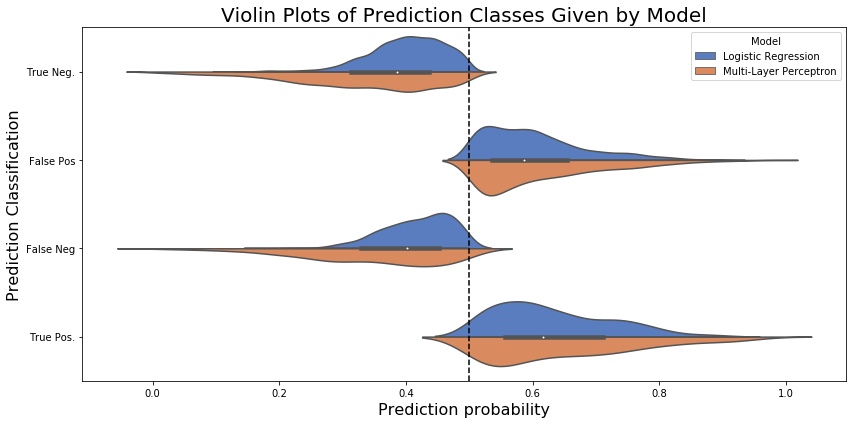

In [222]:
def class_mapping(s):
    if(s[1] == 0): # Truth is negative
        if(s[0] < 0.5):
            return "True Neg."
        else:
            return "False Pos."
    else: # Truth is positive
        if(s[0] < 0.5):
            return "False Neg."
        else:
            return "True Pos."
    
distribution_LRC = pd.DataFrame({'Prediction': y_proba_LRC, 
                                            'Truth': y_test,
                                            'Class Type': np.ones(len(y_test)),
                                            'Model': 'Logistic Regression'})

distribution_MLPC = pd.DataFrame({'Prediction': y_proba_MLPC, 
                                            'Truth': y_test,
                                            'Class Type': np.ones(len(y_test)),
                                            'Model': 'Multi-Layer Perceptron'})

# Create the dataframe that holds the data we need for violin plots
prediction_distribution = pd.concat([distribution_LRC, distribution_MLPC], 
                                    axis=0, ignore_index=True).reset_index(drop=True)
prediction_distribution['Class Type'] = np.apply_along_axis(class_mapping, 
                                                            1, prediction_distribution)

plt.figure(figsize=(12,6))
sns.violinplot(x="Prediction", y="Class Type", hue="Model",
               data=prediction_distribution, palette="muted", split=True);
plt.title("Violin Plots of Prediction Classes Given by Model", size=20)
plt.xlabel("Prediction probability", size=16)
plt.ylabel("Prediction Classification", size=16)
plt.axvline(0.5, color="k", linestyle="--")
plt.tight_layout()
plt.savefig("predclass.png")
plt.show()

In [280]:
prediction_distribution[['Class Type', 'Prediction']][prediction_distribution['Model'] \
        == 'Multi-Layer Perceptron'].groupby('Class Type').describe().T

Class Type          False Neg     False Pos     True Neg.    True Pos.
Prediction count 347.00000000 1818.00000000 4552.00000000 281.00000000
           mean    0.34676809    0.61425833    0.32946110   0.64872502
           std     0.10833672    0.09552348    0.11299030   0.11625313
           min     0.01118643    0.50008848    0.00028999   0.50075273
           25%     0.27488070    0.53481199    0.25413599   0.54348179
           50%     0.36849888    0.58613367    0.34450723   0.62697313
           75%     0.43388743    0.66979576    0.41716304   0.72343948
           max     0.49960713    0.97572233    0.49947829   0.96466483

## Qualify Features
Which components of the feature space give the most likelihood for readmission (or preventative measures against readmission)?

In [101]:
# Create a RandomForestClassifier and support the Gini Importances of each feature
RFC = RandomForestClassifier(n_estimators=250, class_weight='balanced', random_state=0, n_jobs=-1)
RFC = RFC.fit(X_train_significant, y_train)

trees_std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
importances = RFC.feature_importances_

#### Create the feature quality dataframe which will capture the feature qualities we are interested in

In [229]:
feature_quality = pd.DataFrame({'Gini Importance': importances, 
                                'GI Std dev': trees_std,
                                }, index=X_train_significant.columns)

feature_quality['Gini Rank'] = pd.Series(feature_quality['Gini Importance'] \
                                         .rank(ascending=False).astype(int), 
                                         index=feature_quality.index)

feature_quality['Model Coef'] = pd.Series(LRC_model.best_estimator_.coef_[0], 
                                          index=feature_quality.index)

feature_quality['Relative Risk'] = (feature_quality['Model Coef'])/len(X_train_significant.columns)

feature_quality['Coef Rank'] = pd.Series(feature_quality['Model Coef'] \
                                         .rank(ascending=False).astype(int), 
                                         index=feature_quality.index)

feature_quality['pvalue'] = feature_significance[feature_significance['pvalue'] < p_critical]

#### Show the feature quality with respect to Gini Importance Rank

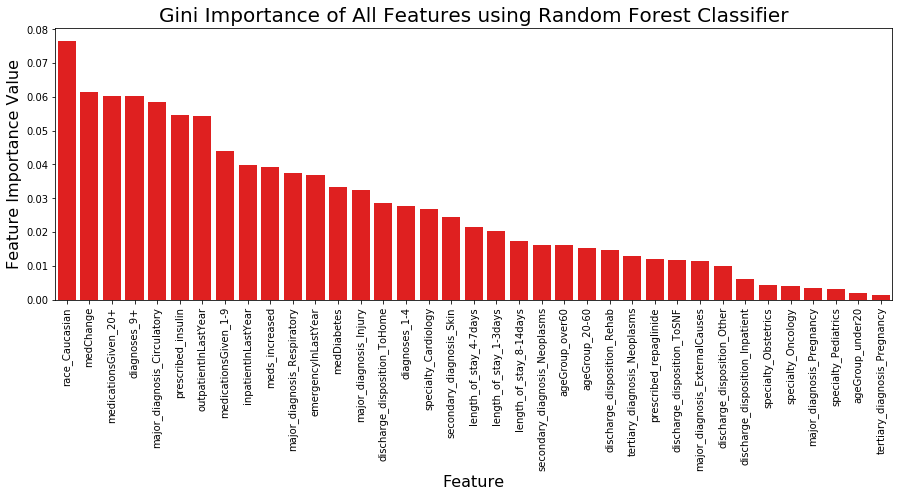

In [231]:
feature_weights = feature_quality.sort_values('Gini Rank', axis=0)

plt.figure(figsize=(15,5))
sns.barplot(x=feature_weights['Gini Rank'].index, 
            y=feature_weights['Gini Importance'].values, color='red')
plt.title("Gini Importance of All Features using Random Forest Classifier", size=20)
plt.xlabel("Feature", size=16)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance Value", size=16)
plt.show()

#### Show the feature quality with respect to Coefficient Rank

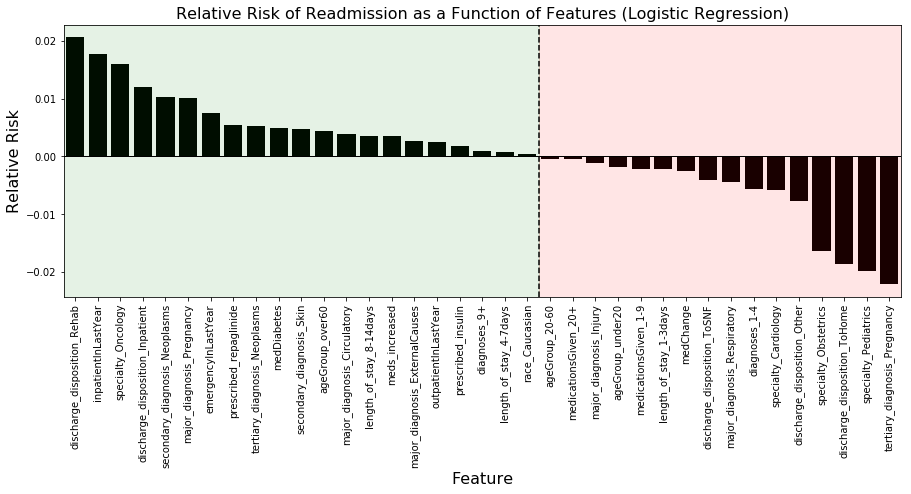

In [136]:
feature_weights = feature_quality.sort_values('Coef Rank', axis=0)

plt.figure(figsize=(15,5))
sns.barplot(x=feature_weights['Coef Rank'].index,
            y=feature_weights['Relative Risk'].values,
            color='black')
plt.title("Relative Risk of Readmission as a Function of Features (Logistic Regression)", size=16)
plt.xlabel("Feature", size=16)
plt.xticks(rotation=90)
plt.ylabel("Relative Risk", size=16)
plt.axvline(20.5, color="k", linestyle="--")
plt.axhline(0, color="k", linestyle="-", linewidth=1)
plt.axvspan(-0.5, 20.5, color='green', alpha=0.1)
plt.axvspan(20.5, 36.5, color='red', alpha=0.1)
plt.xlim(-0.5, 36.5)
plt.show()

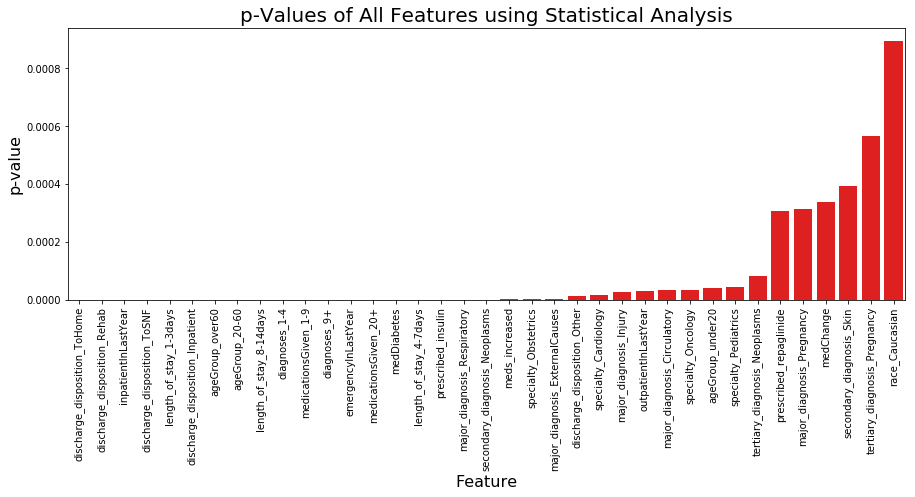

In [105]:
feature_weights = feature_quality.sort_values('pvalue', axis=0)

plt.figure(figsize=(15,5))
sns.barplot(x=feature_weights['pvalue'].index, 
            y=feature_weights['pvalue'].values, color='red')
plt.title("p-Values of All Features using Statistical Analysis", size=20)
plt.xlabel("Feature", size=16)
plt.xticks(rotation=90)
plt.ylabel("p-value", size=16)
plt.show()

In [281]:
feature_weights[['Gini Importance', 'Model Coef', 'Relative Risk','pvalue']]

,Gini Importance,Model Coef,Relative Risk,pvalue
race_Caucasian,0.07660059,0.01614777,0.00043643,0.00089530
medChange,0.06135283,-0.09391583,-0.00253827,0.00033718
medicationsGiven_20+,0.06028754,-0.01801023,-0.00048676,0.00000000
diagnoses_9+,0.06016499,0.03776605,0.00102070,0.00000000
major_diagnosis_Circulatory,0.05846316,0.14444596,0.00390394,0.00003133
prescribed_insulin,0.05456211,0.06569723,0.00177560,0.00000001
outpatientInLastYear,0.05435223,0.09365618,0.00253125,0.00002840
medicationsGiven_1-9,0.04384558,-0.07980758,-0.00215696,0.00000000
inpatientInLastYear,0.03981376,0.65843731,0.01779560,0.00000000
meds_increased,0.03919048,0.13094006,0.00353892,0.00000021
